In [1]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import topn
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(r'C:\Users\fleur\Thesis B3\RQ0\RobustnessOfMetaMF-master\RobustnessOfMetaMF-master\ThesisData\ml-100k\ml-100k\u.user', sep='|', names=u_cols, encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(r'C:\Users\fleur\Thesis B3\RQ0\RobustnessOfMetaMF-master\RobustnessOfMetaMF-master\ThesisData\ml-100k\ml-100k\u.data', sep='\t', names=r_cols, encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv(r'C:\Users\fleur\Thesis B3\RQ0\RobustnessOfMetaMF-master\RobustnessOfMetaMF-master\ThesisData\ml-100k\ml-100k\u.item', sep='|', names=m_cols, usecols=range(5), encoding='latin-1')

movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

In [4]:
movie_ratings_clean = movie_ratings.drop(["title", "release_date", "video_release_date", "imdb_url", "timestamp"], axis=1)
user_item_matrix = movie_ratings_clean.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)

users_index = users.set_index('user_id')

user_info_item_matrix = user_item_matrix.join(users_index)
user_info_item_matrix.head()

,1,2,3,4,5,6,7,8,9,10,...,1677,1678,1679,1680,1681,1682,age,gender,occupation,zip_code
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24,M,technician,85711
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53,F,other,94043
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23,M,writer,32067
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24,M,technician,43537
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33,F,other,15213


## Movie details 

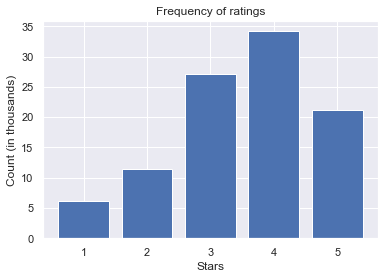

In [10]:
x = ratings.rating.value_counts().index  
y = [ratings['rating'].value_counts()[i]/1000 for i in x]  

plt.bar(x,y, align='center') 
plt.xlabel('Stars')
plt.ylabel('Count (in thousands)')
plt.title('Frequency of ratings')
plt.savefig("ML100K_star_distribution.pdf") 
plt.show()

In [6]:
print("unique movies: ",len(movies["title"].unique()))
print("unique movies id's: ",len(movies["movie_id"].unique()))
print("amount of ratings: ",len(ratings["movie_id"]))
print("amount of users: ",len(users["user_id"]))
print("Amount of duplicates = ",len(movies["movie_id"].unique()) - len(movies["title"].unique()))

# Calculating sparsity in % for ML100K
data = ratings.copy()
unique_users = data.user_id.nunique()
unique_items = data.movie_id.nunique()
sparsity = 1 - (len(data) / (unique_users * unique_items))
print ("nbr users" , len (data.user_id.unique()))
print ("nbr items" , len (data.movie_id.unique()))
print("interaction matrix sparsity: {}%".format(round(100 * sparsity, 1)))

unique movies:  1664
unique movies id's:  1682
amount of ratings:  100000
amount of users:  943
Amount of duplicates =  18
93.69533063577546
nbr users 943
nbr items 1682
interaction matrix sparsity: 93.7%
95.8097794393651
98.30317267467883


In [8]:
(len(data) / (unique_users * unique_items)) * 100

6.304669364224531

## Age details

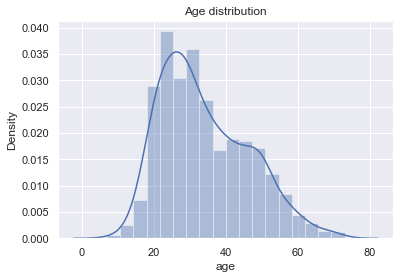

In [62]:
sns.set()    
sns.distplot(users.age)
plt.title('Age distribution')
plt.savefig("ML100K_age_distribution.pdf") 
plt.show()

## Gender details

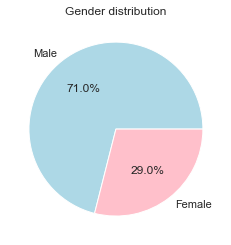

In [22]:
plt.pie(users["gender"].value_counts(), labels =["Male", "Female"], colors=['lightblue','pink'], autopct='%1.1f%%' )
plt.title('Gender distribution')
plt.savefig("ML100K_genderpie.pdf")  
plt.show()

## Rating details

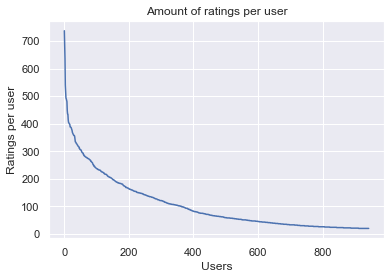

In [21]:
user_ratings = ratings["user_id"].value_counts().sort_values(ascending=False)
xa = np.linspace(0, len(user_ratings), len(user_ratings))
plt.plot(xa, user_ratings)
plt.title('Amount of ratings per user')
plt.xlabel('Users')
plt.ylabel('Ratings per user')
plt.savefig("ML100K_userrating.pdf")  
plt.show()

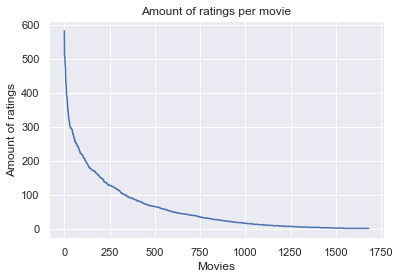

In [19]:
movie_ratings = ratings["movie_id"].value_counts().sort_values(ascending=False)
xa = np.linspace(0,len(movie_ratings), len(movie_ratings))
plt.plot(xa, movie_ratings)
plt.title('Amount of ratings per movie')
plt.xlabel('Movies')
plt.ylabel('Amount of ratings')
plt.savefig("ML100K_movierating.pdf")  
plt.show()

In [5]:
ratings['timestamp'] = ratings['timestamp'].apply(datetime.fromtimestamp)
ratings['year'] = ratings['timestamp'].dt.year
ratings['month'] = ratings['timestamp'].dt.month
ratings['date'] = ratings['timestamp'].dt.date
ratings = ratings.sort_values('timestamp').reset_index(drop=True)

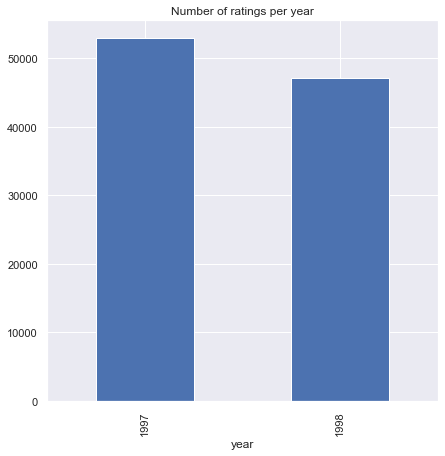

In [9]:
ratings[['year', 'rating']].groupby(['year']).count().reset_index().plot.bar(x='year', y='rating', title='Number of ratings per year', figsize=(7, 7), legend = None);
plt.savefig("ML100K_years.pdf") 

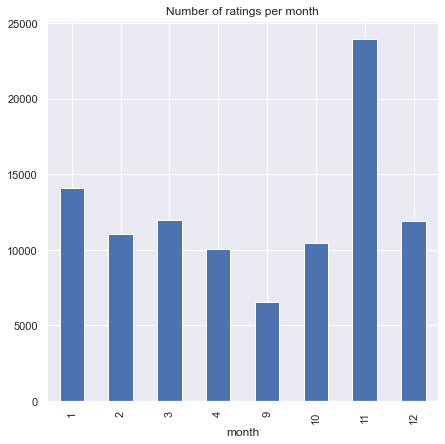

In [8]:
ratings[['month', 'rating']].groupby(['month']).count().reset_index().plot.bar(x='month', y='rating', title='Number of ratings per month', figsize=(7, 7), legend = None);
plt.savefig("ML100K_months.pdf") 